
# Data Preparation

## Imports

In [1]:
import os.path
from os.path import isfile, join
import os
from os import listdir
from osgeo import gdal
import errno
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show

In [2]:
# for coloured print statements
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [3]:
path_labels = os.getcwd() + "/1_labeled_data/tif/"
path_rdg = "/home/jovyan/work/satellite_data/"
label_tif = path_labels + "22-01-05.TIF"

In [4]:
def print_files(path = os.getcwd()):
    onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]
    print(path, onlyfiles)
print_files(path_labels)

/home/jovyan/work/saved_data/Semantic_Segmentation_of_Tree_Stock/1_labeled_data/tif/ ['22-01-05-uploaded.tif', '22-01-05.TIF', 'check-labels-jp2-capizalized-22-01-05.TIF', 'labels-jp2-tif-22.01-05.tif', '22-01-05-test-3-without-tif.tif', 'now.tif', '22-01-30.tif', '22-01-06-with-tif.tif']


### 0.1 Data Inspection

In [5]:
# Import Image with GDAL
dataset = gdal.Open(path_rdg + "2629BD_2018.tif")

In [6]:
# General Dataset Information
def inspect_tif(dataset):
    # print("1. General TIF Data:")
    # print("Metadata:",7 dataset.GetMetadata())
    # print("Type Image: ", type(dataset))
    # print("Projection: ", dataset.GetProjection())
    # print("Size is {} x {} x {}".format(dataset.RasterXSize,
    #                                 dataset.RasterYSize,
    #                                 dataset.RasterCount))
    # print("Driver: {}/{}".format(dataset.GetDriver().ShortName,
    #                         dataset.GetDriver().LongName))
    # geotransform = dataset.GetGeoTransform()
    # if geotransform:
    #     print("Origin = ({}, {})".format(geotransform[0], geotransform[3]))
    #     print("Pixel Size = ({}, {})".format(geotransform[1], geotransform[5]))

    # Raster Band
    band = dataset.GetRasterBand(1)
    # print("2. Raster Band:")
    # print("Band Type={}".format(gdal.GetDataTypeName(band.DataType)))

    min = band.GetMinimum()
    max = band.GetMaximum()
    if not min or not max:
        (min,max) = band.ComputeRasterMinMax(True)
    print("Min={:.3f}, Max={:.3f}".format(min,max))

    if band.GetOverviewCount() > 0:
        print("Band has {} overviews".format(band.GetOverviewCount()))

    # if band.GetRasterColorTable():
    #     print("Band has a color table with {} entries".format(band.GetRasterColorTable().GetCount()))
        
    size_x_px = dataset.RasterXSize
    size_y_px = dataset.RasterYSize
    pixel_size = (dataset.GetGeoTransform()[1], dataset.GetGeoTransform()[1])
    size_x = size_x_px * pixel_size[0]
    size_y = size_y_px * pixel_size[1]
    print("# Pixels in Image = ({}, {}) with a Raster Count of {}".format(size_x_px, size_y_px, dataset.RasterCount))
    print("Size of one Pixel in cm = {}".format(tuple([100*x for x in pixel_size])))
    print("Size Covered by Image / Image Size = ({}m, {}m)".format(size_x, size_y))
inspect_tif(dataset)

Min=0.000, Max=255.000
Band has 8 overviews
# Pixels in Image = (108224, 107798) with a Raster Count of 3
Size of one Pixel in cm = (0.00023728143101288307, 0.00023728143101288307)
Size Covered by Image / Image Size = (0.2567954558993826m, 0.2557846370032677m)


In [7]:
some_dataset = gdal.Open(path_rdg + "2627DC_2018.tif")
inspect_tif(some_dataset)

Min=0.000, Max=240.000
Band has 8 overviews
# Pixels in Image = (107608, 107249) with a Raster Count of 3
Size of one Pixel in cm = (0.00023770193857792506, 0.00023770193857792506)
Size Covered by Image / Image Size = (0.2557863020649336m, 0.25493295210543887m)


In [8]:
# optional conversion to np array
# channel = np.array(dataset.GetRasterBand(1).ReadAsArray())
# print(channel.shape)

In [9]:
# Read the raster band as separate variable
#band = dataset.GetRasterBand(1)

# Check type of the variable 'band'
#type(band)

# Data type of the values
#gdal.GetDataTypeName(band.DataType)

In [10]:
# band1 = labels.GetRasterBand(1) # Red channel
# band2 = labels.GetRasterBand(2) # Green channel
# band3 = labels.GetRasterBand(3) # Blue channel

In [11]:
#labels.GetRasterBand()

Idea Training Process:
1. Load training set (labels with corresponding input TIFs)
2. Create cutouts of labeled training data
3. Train model on data
4. Evaluate model

Idea Prediction Process:
5. Create cutouts of unlabeled data
6. Predict cutouts

Function Overview
Training: load labels -> create_cutouts(label_file) -> fit(unlabeled_cutouts, labeled_cutouts) -> evaluate(?)
Prediction: load dats -> create_cutouts(label_file) -> predict(unlabeled_cutouts)

In [12]:
def isfile(filepath: str = None):
    # if filepath does not exists, an error is thrown
    if not os.path.isfile(filepath): raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), filepath) #print("File does not exist.")

In [13]:
import time

In [14]:
def preview_tif(tif_filepath: str = None):
    isfile(tif_filepath)
    img = rasterio.open(tif_filepath)
    print(tif_filepath)
    if img: show(img)
    else: print("img unable to be loaded at this moment")

In [15]:
def create_cutouts(path_label, label_file):
    cutout_id = 0 # TODO: WHEN LOOPED OVER, THIS SHOULD BE REPLACED TO KEEP TRACK OF CUTOUTS
    
    # upper/lower (u/l) left/right (l/r) coordinates 
    ulx, xres, xskew, uly, yskew, yres  = label_file.GetGeoTransform()
    width, height = label_file.RasterXSize, label_file.RasterYSize
    lrx = ulx + width * xres
    lry = uly + height * yres
    # corner & cener coordinates can be checked in the terminal with 
    # $ gdalinfo '/home/jovyan/work/satellite_data/FILE.tif'
    # determine cutout window of size: 512x512 px
    cutout_size = 512
    crop_ulx = ulx
    crop_uly = uly
    crop_lrx = ulx + cutout_size * xres
    crop_lry = uly + cutout_size * yres
    cropped_window = (crop_ulx,crop_uly,crop_lrx,crop_lry)
    print("cropped window:", cropped_window)
    # export cropped raster
    cutouts_path = os.getcwd() + "/2_cutouts/"
    cutout_filename = path_label.replace(".tif", "") + "-" + str(cutout_id) + ".tif"
    cutout_path = cutouts_path + cutout_filename
    # print(f"Cutout: {bcolors.OKBLUE}{cutout_path}{bcolors.ENDC}")
    gdal.Translate(cutout_path, label_file, projWin = cropped_window) #label_file is the tif file
    
    # preview tif
    #load_tif([cutout_path])
    cutout = gdal.Open(cutout_path)
    # check if gdal is able to open file
    if cutout:
        print(f"{bcolors.OKGREEN}0 Success:{bcolors.ENDC} {bcolors.OKBLUE}{cutout_filename}{bcolors.ENDC}") # complete path: cutout_path
        inspect_tif(cutout)
    preview_tif(cutout_path)
    
    # close tif
    cutout_path, label_file, cropped_window = None, None, None

In [16]:
def load_tif(label_files: list = None, subdivide_img: bool = False):
    # loop through array of file names
    for path_label in label_files:
        path_label_file = path_labels + path_label
        # check if filepath exists
        if not os.path.isfile(path_label_file):
            print("Filepath does not exist: {}".format(path_label_file)) 
            continue
        # open file
        label_file = gdal.Open(path_label_file)
        # check if gdal is able to open file
        if label_file:
            # print(f"{bcolors.OKBLUE}{path_label}{bcolors.ENDC}")
            print(f"{bcolors.OKGREEN}0 Success:{bcolors.ENDC} {bcolors.OKBLUE}{path_label}{bcolors.ENDC}") # complete path: path_label_file
            inspect_tif(label_file)
            if subdivide_img:
                # create cutouts
                create_cutouts(path_label, label_file)
            continue
        print(f"{bcolors.FAIL}1 Failure:{bcolors.ENDC}" + path_label_file) #"File cannot be loaded." #"Filepath exists: ", os.path.isfile(tif_filepath), 

### 0.2 Load Labels

In [17]:
label_files = ["22-01-30.tif"] #, "now.tif"

0 Success: 22-01-30.tif
Min=80.000, Max=255.000
# Pixels in Image = (4112, 11377) with a Raster Count of 4
Size of one Pixel in cm = (0.0015679484435797747, 0.0015679484435797747)
Size Covered by Image / Image Size = (0.06447404000000034m, 0.17838549442607096m)
cropped window: (29.748224553, -26.248672807786964, 29.756252449031127, -26.25670070381809)
0 Success: 22-01-30-0.tif
Min=80.000, Max=255.000
# Pixels in Image = (512, 512) with a Raster Count of 4
Size of one Pixel in cm = (0.0015679484435797747, 0.0015679484435797747)
Size Covered by Image / Image Size = (0.008027896031128447m, 0.008027896031128447m)
/home/jovyan/work/saved_data/Semantic_Segmentation_of_Tree_Stock/2_cutouts/22-01-30-0.tif


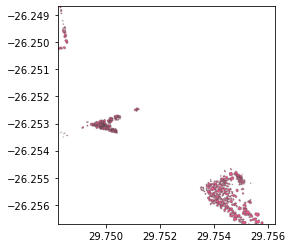

In [18]:
load_tif(label_files, True)

# Backlog

In [19]:
#check if all (label) files in a directory are loadable
def check_all_labels(directory = os.fsencode(path_labels)):
    print("Labels")    
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.endswith(".tif") or filename.endswith(".TIF") or filename.endswith(".tiff"): 
            print(filename)
            load_tif(path_labels + filenyame)
            print("")
            continue
        else:
            continue
#check_all_labels(os.fsencode(path_labels))

In [20]:
# No. of Bands, Image resolution (X, Y), CRS (Coordinate Reference System)
# print(label.count, label.height, label.width, label.crs)